# (30) BALLS—Test—0

**Motivation**: Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## <conv|lin>

In [4]:
tr, meta = load_model(
    'poisson_uniform_c(-3)_rmax(1)_BALLS_z-16_k-32_<conv+b|lin>',
    'mc_b200-ep500-lr(0.002)_beta(0.8:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_01,08:37)',
    # 'poisson_uniform_c(-3)_rmax(1)_BALLS_z-128_k-32_<conv+b|lin>',
    # 'mc_b200-ep500-lr(0.002)_beta(5:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_01,07:26)',
    # 'poisson_uniform_c(-3)_rmax(1)_BALLS_z-32_k-64_<conv+b|lin>',
    # 'mc_b200-ep500-lr(0.002)_beta(0.1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_01,07:27)',
    device=device,
)
print(meta)

{
    'timestamp': '2024_05_01,08:37',
    'checkpoint': 350,
    'global_step': 105000,
    'file': 'PoissonVAE+TrainerVAE-0350_(2024_05_01,09:23).pt',
    'path': 
'/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(1)_BALLS_z-16_k-32_<conv+b|lin>/mc_b200-ep500-lr(
0.002)_beta(0.8:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_01,08:37)'
}

In [5]:
%%time

temp = 0.0

data, loss, etc = {}, {}, {}
for e in ['trn', 'vld', 'tst']:
    data[e], loss[e], etc[e] = tr.forward(
        dl_name=e, temp=temp, full_data=True)
loss_avg = {
    name: {k: v.mean() for k, v in d.items()}
    for name, d in loss.items()
}

CPU times: user 19.5 s, sys: 371 ms, total: 19.9 s
Wall time: 7.08 s


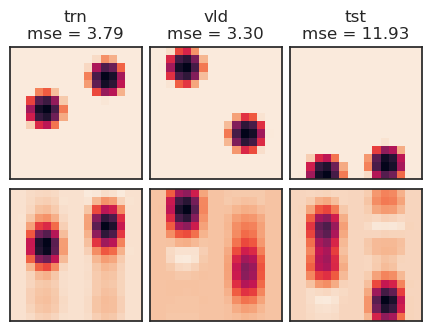

In [6]:
sample_i = 412

fig, axes = create_figure(2, 3, (4.2, 3.2), 'all', 'all', 'constrained')
for i, name in enumerate(data):
    _a = data[name]['x'][sample_i, 0]
    _b = data[name]['y'][sample_i, 0]
    mse = np.linalg.norm(_a - _b) ** 2
    axes[0, i].set_title(f"{name}\nmse = {mse:0.2f}")

    axes[0, i].imshow(_a, cmap='rocket_r')
    axes[1, i].imshow(_b, cmap='rocket_r')
remove_ticks(axes, False)
plt.show()

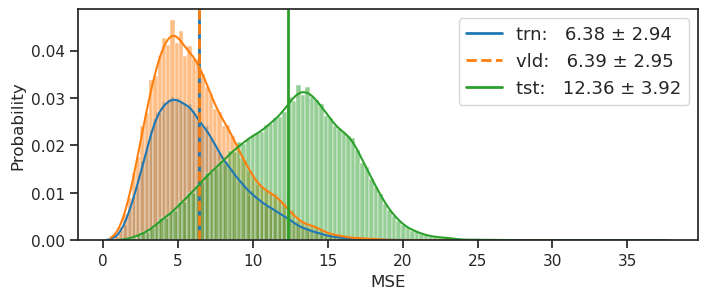

In [7]:
fig, ax = create_figure(1, 1, (8, 3))
for i, (name, d) in enumerate(loss.items()):
    sns.histplot(d['mse'], stat='probability', kde=True, color=f"C{i}", ax=ax)
    _a = d['mse'].mean()
    _s = d['mse'].std()
    ls = '--' if name == 'vld' else '-'
    ax.axvline(_a, ls=ls, lw=2, color=f"C{i}", label=f"{name}:   {_a:0.2f} ± {_s:0.2f}")
ax.legend(fontsize=13)
ax.set_xlabel('MSE')
plt.show()

In [8]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

In [9]:
var = 'log_dr'

lr = LinearRegression().fit(
    X=etc['trn'][var],
    y=data['trn']['g'][:, [1, 3]],
)
r2 = {
    name: r2_score(
        y_true=d['g'][:, [1, 3]],
        y_pred=lr.predict(etc[name][var]),
        multioutput='raw_values')
    for name, d in data.items()
}
corr = {
    name: 1 - np.diag(sp_dist.cdist(
        XA=d['g'][:, [1, 3]].T,
        XB=lr.predict(etc[name][var]).T,
        metric='correlation',
    )) for name, d in data.items()
}

In [10]:
print(f"r2:", r2, '\nCorr:', corr)

r2:
{
    'trn': array([0.98122342, 0.97584758]),
    'vld': array([0.98153674, 0.97600472]),
    'tst': array([-2.20335498, -0.70318418])
}

Corr:
{
    'trn': array([0.99056722, 0.98784998]),
    'vld': array([0.99072864, 0.98793013]),
    'tst': array([0.56929335, 0.70708603])
}

## <conv|mlp>

In [4]:
tr, meta = load_model(
    'poisson_uniform_c(-3)_rmax(1)_BALLS_z-32_k-32_<conv+b|mlp+b>',
    'mc_b200-ep500-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_04_30,22:59)',
    device=device,
)
print(meta)

{
    'timestamp': '2024_04_30,22:59',
    'checkpoint': 500,
    'global_step': 150000,
    'file': 'PoissonVAE+TrainerVAE-0500_(2024_04_30,23:57).pt',
    'path': 
'/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(1)_BALLS_z-32_k-32_<conv+b|mlp+b>/mc_b200-ep500-l
r(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_04_30,22:59)'
}

In [5]:
%%time

temp = 0.0

data, loss, etc = {}, {}, {}
for e in ['trn', 'vld', 'tst']:
    data[e], loss[e], etc[e] = tr.forward(
        dl_name=e, temp=temp, full_data=True)
loss_avg = {
    name: {k: v.mean() for k, v in d.items()}
    for name, d in loss.items()
}

CPU times: user 15.8 s, sys: 330 ms, total: 16.2 s
Wall time: 3.85 s


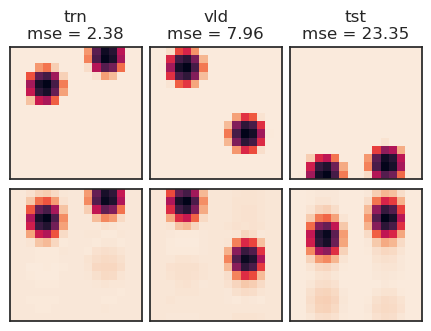

In [6]:
sample_i = 412

fig, axes = create_figure(2, 3, (4.2, 3.2), 'all', 'all', 'constrained')
for i, name in enumerate(data):
    _a = data[name]['x'][sample_i, 0]
    _b = data[name]['y'][sample_i, 0]
    mse = np.linalg.norm(_a - _b) ** 2
    axes[0, i].set_title(f"{name}\nmse = {mse:0.2f}")

    axes[0, i].imshow(_a, cmap='rocket_r')
    axes[1, i].imshow(_b, cmap='rocket_r')
remove_ticks(axes, False)
plt.show()

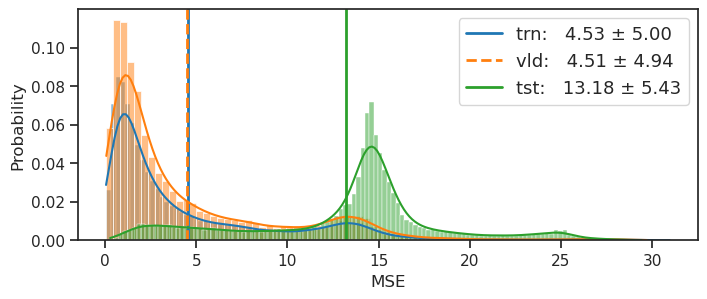

In [7]:
fig, ax = create_figure(1, 1, (8, 3))
for i, (name, d) in enumerate(loss.items()):
    sns.histplot(d['mse'], stat='probability', kde=True, color=f"C{i}", ax=ax)
    _a = d['mse'].mean()
    _s = d['mse'].std()
    ls = '--' if name == 'vld' else '-'
    ax.axvline(_a, ls=ls, lw=2, color=f"C{i}", label=f"{name}:   {_a:0.2f} ± {_s:0.2f}")
ax.legend(fontsize=13)
ax.set_xlabel('MSE')
plt.show()

In [8]:
var = 'log_dr'

lr = LinearRegression().fit(
    X=etc['trn'][var],
    y=data['trn']['g'][:, [1, 3]],
)
r2 = {
    name: r2_score(
        y_true=d['g'][:, [1, 3]],
        y_pred=lr.predict(etc[name][var]),
        multioutput='raw_values')
    for name, d in data.items()
}
corr = {
    name: 1 - np.diag(sp_dist.cdist(
        XA=d['g'][:, [1, 3]].T,
        XB=lr.predict(etc[name][var]).T,
        metric='correlation',
    )) for name, d in data.items()
}

In [9]:
print(f"r2:", r2, '\nCorr:', corr)

r2:
{
    'trn': array([0.98570283, 0.99213695]),
    'vld': array([0.98579353, 0.99222981]),
    'tst': array([-2.4640948 ,  0.86338526])
}

Corr:
{
    'trn': array([0.99282568, 0.99606072]),
    'vld': array([0.9928722 , 0.99610749]),
    'tst': array([0.50333677, 0.94646166])
}

In [10]:
true = data['tst']['g'][:, [1, 3]]
pred = lr.predict(etc['tst'][var])

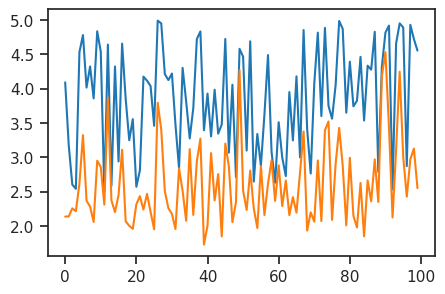

In [11]:
plt.plot(true[:100, 0])
plt.plot(pred[:100, 0])

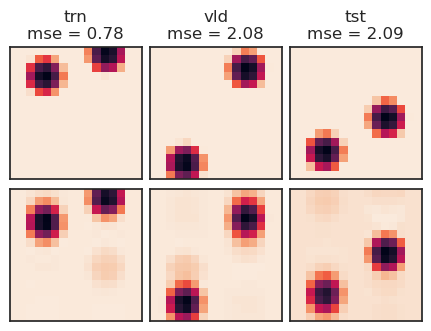

In [12]:
sample_i = 418

fig, axes = create_figure(2, 3, (4.2, 3.2), 'all', 'all', 'constrained')
for i, name in enumerate(data):
    _a = data[name]['x'][sample_i, 0]
    _b = data[name]['y'][sample_i, 0]
    mse = np.linalg.norm(_a - _b) ** 2
    axes[0, i].set_title(f"{name}\nmse = {mse:0.2f}")

    axes[0, i].imshow(_a, cmap='rocket_r')
    axes[1, i].imshow(_b, cmap='rocket_r')
remove_ticks(axes, False)
plt.show()

## <conv|conv>

another: z dim = 4

In [13]:
tr, meta = load_model(
    'poisson_uniform_c(-3)_rmax(1)_BALLS_z-4_k-32_<conv+b|conv+b>',
    'mc_b200-ep500-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_01,00:02)',
    device=device,
)
print(meta)

{
    'timestamp': '2024_05_01,00:02',
    'checkpoint': 500,
    'global_step': 150000,
    'file': 'PoissonVAE+TrainerVAE-0500_(2024_05_01,01:27).pt',
    'path': 
'/home/hadi/Projects/PoissonVAE/models/poisson_uniform_c(-3)_rmax(1)_BALLS_z-4_k-32_<conv+b|conv+b>/mc_b200-ep500-l
r(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(500)_(2024_05_01,00:02)'
}

In [14]:
%%time

temp = 0.0

data, loss, etc = {}, {}, {}
for e in ['trn', 'vld', 'tst']:
    data[e], loss[e], etc[e] = tr.forward(
        dl_name=e, temp=temp, full_data=True)
loss_avg = {
    name: {k: v.mean() for k, v in d.items()}
    for name, d in loss.items()
}

CPU times: user 17 s, sys: 234 ms, total: 17.3 s
Wall time: 4.95 s


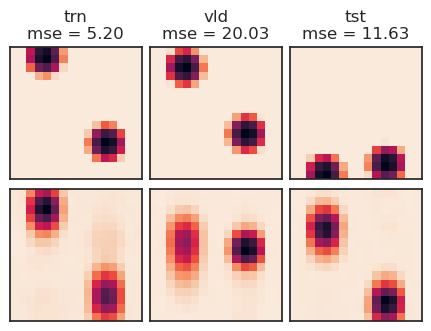

In [15]:
sample_i = 412

fig, axes = create_figure(2, 3, (4.2, 3.2), 'all', 'all', 'constrained')
for i, name in enumerate(data):
    _a = data[name]['x'][sample_i, 0]
    _b = data[name]['y'][sample_i, 0]
    mse = np.linalg.norm(_a - _b) ** 2
    axes[0, i].set_title(f"{name}\nmse = {mse:0.2f}")

    axes[0, i].imshow(_a, cmap='rocket_r')
    axes[1, i].imshow(_b, cmap='rocket_r')
remove_ticks(axes, False)
plt.show()

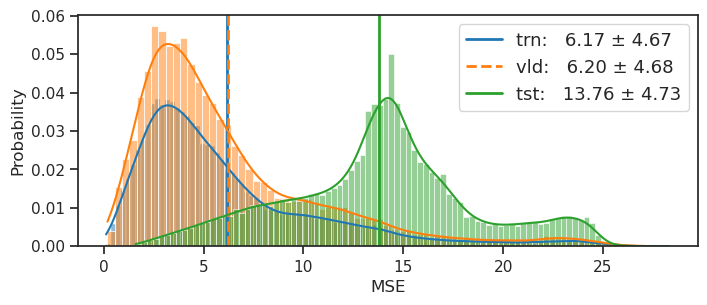

In [16]:
fig, ax = create_figure(1, 1, (8, 3))
for i, (name, d) in enumerate(loss.items()):
    sns.histplot(d['mse'], stat='probability', kde=True, color=f"C{i}", ax=ax)
    _a = d['mse'].mean()
    _s = d['mse'].std()
    ls = '--' if name == 'vld' else '-'
    ax.axvline(_a, ls=ls, lw=2, color=f"C{i}", label=f"{name}:   {_a:0.2f} ± {_s:0.2f}")
ax.legend(fontsize=13)
ax.set_xlabel('MSE')
plt.show()

In [17]:
var = 'log_dr'

lr = LinearRegression().fit(
    X=etc['trn'][var],
    y=data['trn']['g'][:, [1, 3]],
)
r2 = {
    name: r2_score(
        y_true=d['g'][:, [1, 3]],
        y_pred=lr.predict(etc[name][var]),
        multioutput='raw_values')
    for name, d in data.items()
}
corr = {
    name: 1 - np.diag(sp_dist.cdist(
        XA=d['g'][:, [1, 3]].T,
        XB=lr.predict(etc[name][var]).T,
        metric='correlation',
    )) for name, d in data.items()
}

In [18]:
print(f"r2:", r2, '\nCorr:', corr)

r2:
{
    'trn': array([0.80197483, 0.85691447]),
    'vld': array([0.80473846, 0.85718998]),
    'tst': array([-1.06057694,  0.09273036])
}

Corr:
{
    'trn': array([0.89553048, 0.92569675]),
    'vld': array([0.89707271, 0.92585118]),
    'tst': array([0.63401625, 0.68752918])
}

In [19]:
true = data['tst']['g'][:, [1, 3]]
pred = lr.predict(etc['tst'][var])

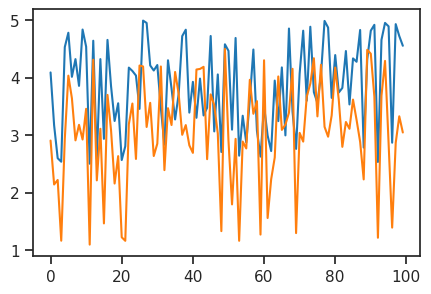

In [20]:
plt.plot(true[:100, 0])
plt.plot(pred[:100, 0])

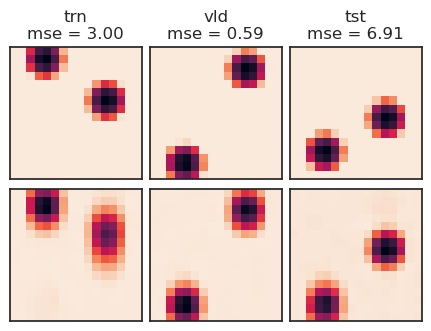

In [21]:
sample_i = 418

fig, axes = create_figure(2, 3, (4.2, 3.2), 'all', 'all', 'constrained')
for i, name in enumerate(data):
    _a = data[name]['x'][sample_i, 0]
    _b = data[name]['y'][sample_i, 0]
    mse = np.linalg.norm(_a - _b) ** 2
    axes[0, i].set_title(f"{name}\nmse = {mse:0.2f}")

    axes[0, i].imshow(_a, cmap='rocket_r')
    axes[1, i].imshow(_b, cmap='rocket_r')
remove_ticks(axes, False)
plt.show()